In [1]:
%load_ext tensorboard

In [2]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

2024-07-31 10:47:40.854832: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 10:47:40.878924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 10:47:40.878962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 10:47:40.879620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 10:47:40.884226: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

In [4]:
# gpu_options = tf.GPUOptions(visible_device_list="0")
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-07-31 10:47:42.141566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-31 10:47:42.170009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-31 10:47:42.170168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


tf.debugging.set_log_device_placement(True)


1 Physical GPUs, 1 Logical GPU


2024-07-31 10:47:42.187636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-31 10:47:42.187967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-31 10:47:42.188141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# import cv2
# import urllib
# import requests
# import PIL.Image

# from bs4 import BeautifulSoup

In [8]:
# #downloading ship synset
# ship_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03095699")
# ship_soup = BeautifulSoup(ship_page.content, "html.parser")

# #downloading bike synset:
# bike_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03792782")
# bike_soup = BeautifulSoup(bike_page.content, "html.parser")

# ship_soup_str = str(ship_soup)
# ship_soup_split_url = ship_soup_str.split("\r\n")

# bike_soup_str = str(bike_soup)
# bike_soup_split_url = bike_soup_str.split("\r\n")

In [9]:
# os.mkdir('./content')
# os.mkdir('./content/train')
# os.mkdir('./content/train/ships')
# os.mkdir('./content/train/bikes')
# os.mkdir('./content/validation')
# os.mkdir('./content/validation/ships')
# os.mkdir('./content/validation/bikes')

In [10]:
# print("le: ", len(bike_soup_split_url))

In [11]:
# image_rows, image_cols = 32, 32

# input_shape = (image_rows, image_cols, 3)

# def url_to_image(url):
#     resp = urllib.request.urlopen(url)
#     image = np.asarray(bytearray(resp.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#     return image

# n_training_images = 100

# #train images for ship
# for progress in tqdm(range(n_training_images)):
#     if not ship_soup_split_url[progress] == None:
#         try:
#             I = url_to_image(ship_soup_split_url[progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/train/ships/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None

# #train images for bikes
# for progress in tqdm(range(n_training_images)):
#     if not bike_soup_split_url[progress] == None:
#         try:
#             I = url_to_image(bike_soup_split_url[progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/train/bikes/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None

# #validation images for ships
# for progress in tqdm(range(50)):
#     if not ship_soup_split_url[n_training_images+progress] == None:
#         try:
#             I = url_to_image(ship_soup_split_url[n_training_images+progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/validation/ships/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None


# #validation images for bikes
# for progress in tqdm(range(50)):
#     if not bike_soup_split_url[n_training_images+progress] == None:
#         try:
#             I = url_to_image(bike_soup_split_url[n_training_images+progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/validation/bikes/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None

In [12]:
#defining model

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(
            96, 
            kernel_size=(11, 11), 
            strides=4, 
            padding="valid", 
            activation="relu", 
            input_shape=input_shape,
            kernel_initializer="he_normal"
        ))
        
        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides = (2, 2),
            padding = "valid",
            data_format = None
        ))

        self.add(Conv2D(
            256,
            kernel_size=(5, 5),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides = (2, 2),
            padding="valid",
            data_format=None
        ))

        self.add(Conv2D(
            384,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(Conv2D(
            384,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(Conv2D(
            256,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding="valid",
            data_format=None
        ))

        self.add(Dropout(0.5))
        self.add(Flatten())
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation="relu"))
        self.add(Dense(4096, activation="relu"))
        self.add(Dense(1000, activation="relu"))
        self.add(Dense(num_classes, activation="softmax"))

        self.compile(
            optimizer=Adam(0.0001),
            loss = 'categorical_crossentropy',
            metrics=["accuracy"]
        )


In [13]:
num_classes = 3

model = AlexNet((227, 227, 3), num_classes)

epochs = 1
batch_size = 32

train_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/Imagenet/synsets"
valid_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/Imagenet/valid_synsets"

Image_height = 227
Image_width = 227

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode="categorical"
)

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=7,
    shuffle=True,
    class_mode="categorical"
)

train_num = train_generator.samples
valid_num = valid_generator.samples

Found 3605 images belonging to 3 classes.
Found 264 images belonging to 3 classes.


In [14]:
model_dir = "/home/abhinav/Documents/Work/Hobby/Models/myalexnet.h5"

In [15]:
# Has to be executed only once
# os.mkdir("./logs")
# os.mkdir("./logs/fit")

In [16]:
log_dir = "./logs/fit" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks_list = [tensorboard_callback]

model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_num//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_num//batch_size,
    callbacks=callbacks_list,
    verbose=1
)

model.summary()

2024-07-31 10:47:42.925399: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-31 10:47:43.635454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inalex_net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-31 10:47:44.038185: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-31 10:47:44.168688: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-31 10:47:45.669270: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a5c08fb36c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-31 10:47:45.669291: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050

112/112 [==============================] - 34s 225ms/step - loss: 0.8499 - accuracy: 0.6563 - val_loss: 0.4070 - val_accuracy: 0.8438
Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       8

In [17]:
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       132

In [18]:
model.save(model_dir)

/home/abhinav/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


x_valid_shape:  (32, 227, 227, 3)
1/1 [==============================] - 0s 101ms/step
predict_x:  [[5.5138577e-02 8.5947961e-01 8.5381769e-02]
 [4.4661504e-03 9.8326367e-01 1.2270207e-02]
 [9.8329028e-03 9.5731407e-01 3.2853100e-02]
 [6.9818699e-01 2.8003225e-01 2.1780726e-02]
 [9.5722657e-03 9.8484808e-01 5.5797063e-03]
 [4.5218724e-01 3.3567026e-01 2.1214248e-01]
 [7.9995853e-01 1.5326743e-01 4.6774037e-02]
 [6.8017858e-04 9.9653327e-01 2.7864778e-03]
 [1.0547490e-03 5.9646717e-03 9.9298060e-01]
 [8.8081926e-02 5.5190986e-01 3.6000827e-01]
 [3.0310791e-02 2.8550750e-02 9.4113845e-01]
 [2.4473781e-02 3.0395868e-01 6.7156756e-01]
 [1.0337472e-02 9.0779829e-01 8.1864208e-02]
 [9.3992448e-01 3.7903171e-02 2.2172341e-02]
 [4.8696786e-01 4.9627307e-01 1.6759027e-02]
 [2.1145047e-01 1.5428878e-01 6.3426071e-01]
 [7.3363637e-03 9.8344111e-01 9.2224991e-03]
 [7.2885137e-03 5.2864399e-02 9.3984711e-01]
 [7.4248514e-03 5.8651646e-03 9.8671001e-01]
 [7.2560656e-01 2.5332522e-01 2.1068189e-02]
 

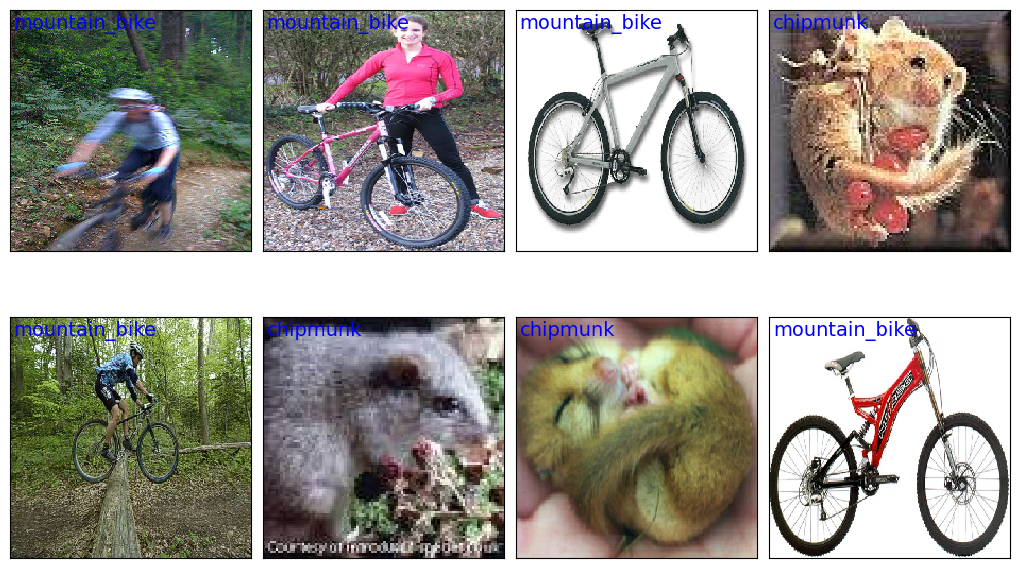

In [19]:
#predictions

class_names = ['chipmunk', 'mountain_bike', 'ship']

x_valid, label_batch = next(iter(valid_generator))
# print("x_valid: ", x_valid)
# print("label_batch: ", label_batch)

print("x_valid_shape: ", x_valid.shape)

predict_x = model.predict(x_valid)
print("predict_x: ", predict_x)
prediction_values = np.argmax(predict_x,axis=1)
print("prediction_values", prediction_values)

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(x_valid[i, :], cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        print("label_batch[i]: ", label_batch[i])
        print("prediction_values[i]:  is the same as np.argmax(label_batch[i])", prediction_values[i])
        print("class_names: ", class_names)
        ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)